In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using GPU: NVIDIA GeForce RTX 4090


In [2]:
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")

In [3]:
from baseline_train import train, create_train_test_dataloaders
from baseline_encoder import AtariPatchEncoder
from tokenizer import MGDTTokenizer
from baseline_model import MultiGameDecisionTransformer
from atari_dataset import AtariDataset

# Configuration
context_len = 32
batch_size = 32
d_model = 128
n_games = 1
train_fraction = 0.5

# Create train and test dataloaders
train_loader, test_loader = create_train_test_dataloaders(
    sequences_by_game,
    total_frac=1,
    train_fraction=train_fraction,
    context_len=context_len,
    batch_size=batch_size,
    num_workers=16,
    seed=1324,
)

# Get n_actions from dataset
n_actions = train_loader.dataset.n_actions()
print(f"Number of actions: {n_actions}")

# Create patch encoder
patch_encoder = AtariPatchEncoder(
    img_size=84,
    patch_size=14,
    in_channels=1,
    d_model=d_model,
)

# Create tokenizer
tokenizer = MGDTTokenizer(
    patch_encoder=patch_encoder,
    n_actions=n_actions,
    n_games=n_games,
    rtg_min=-20,
    rtg_max=100,
)

Train dataset length: 78357
Test dataset length: 82230
Number of actions: 9


Generating action distribution analysis...


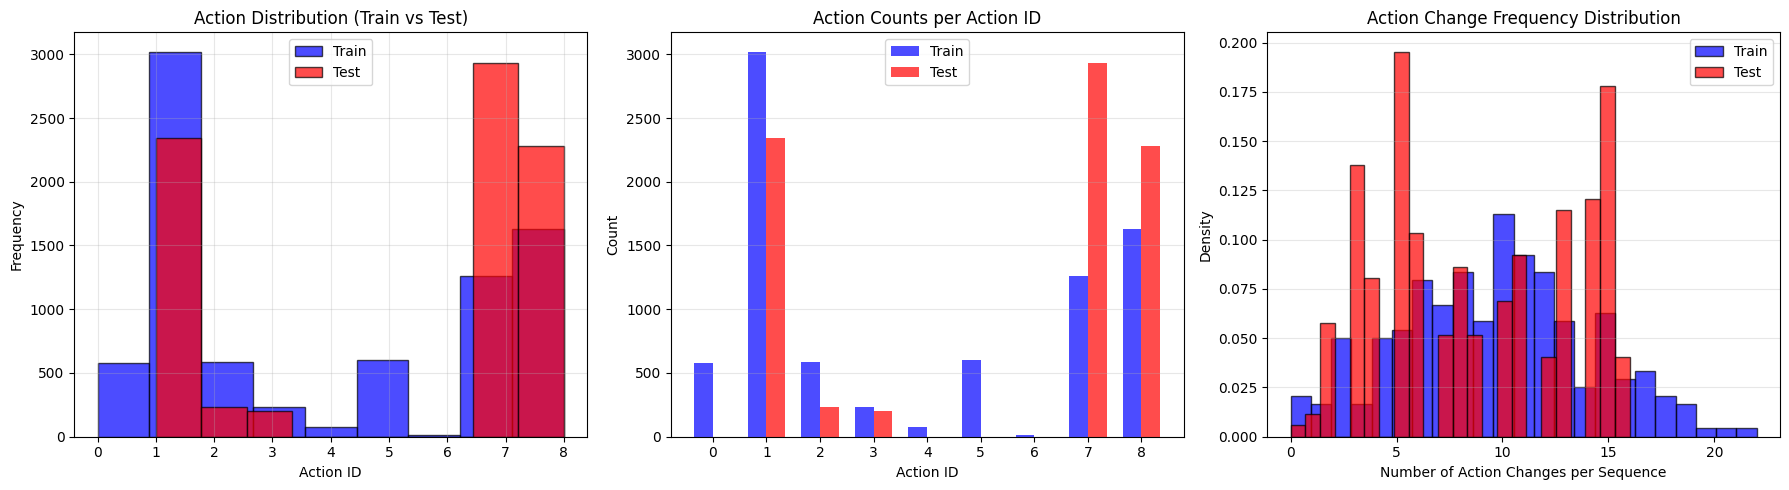


=== Action Change Statistics ===
Train - Mean changes per sequence: 9.54 ± 4.64
Train - Range: [0, 22]
Test  - Mean changes per sequence: 8.81 ± 4.52
Test  - Range: [0, 16]
Generating RTG distribution analysis...


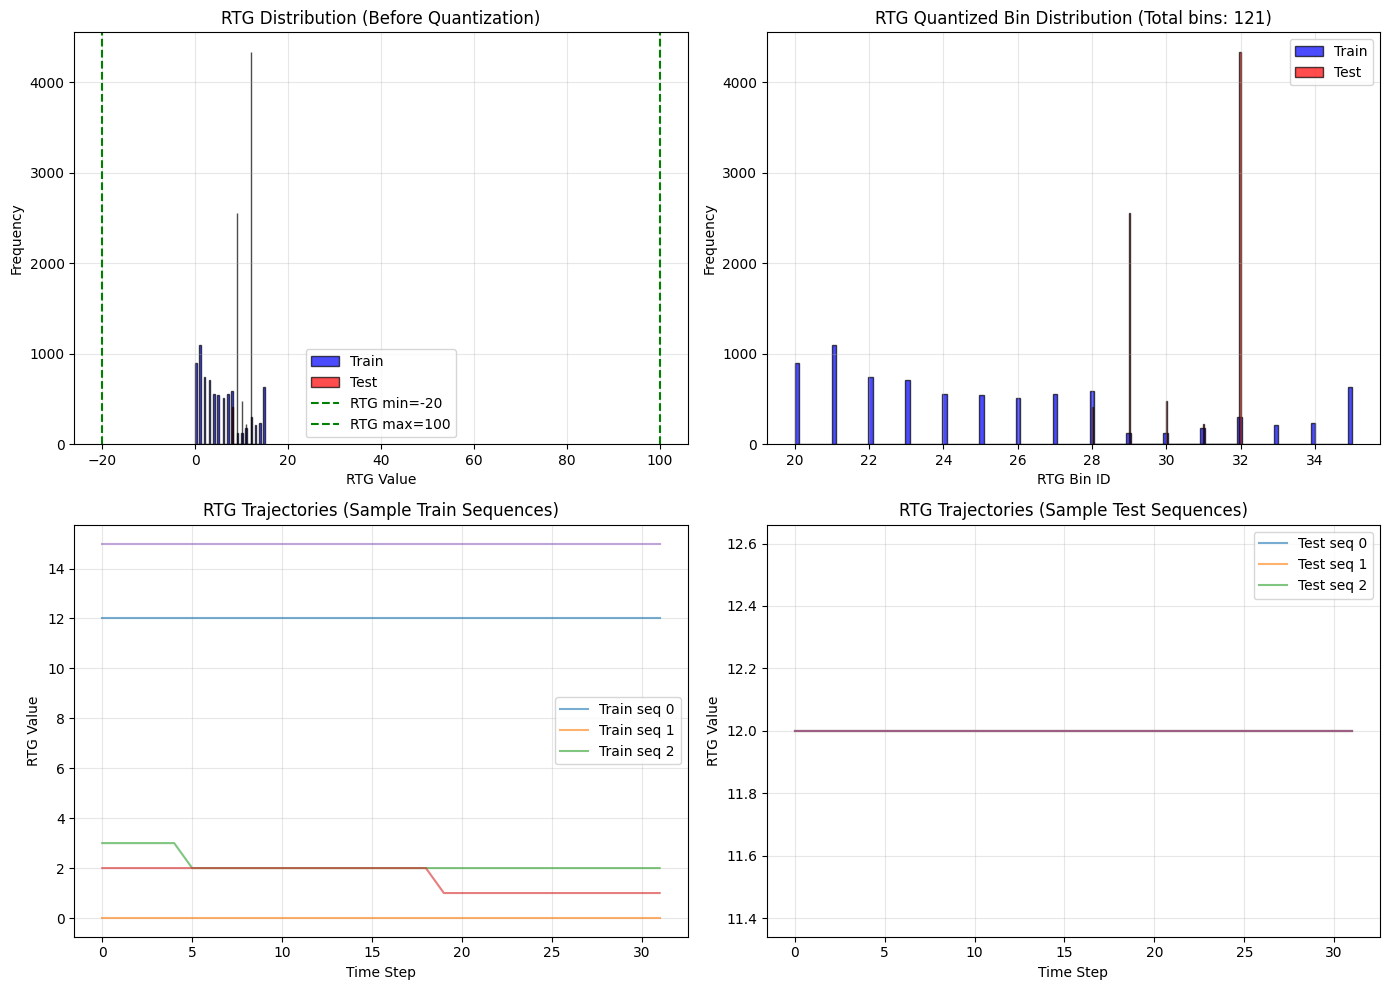

Generating image encoding analysis...


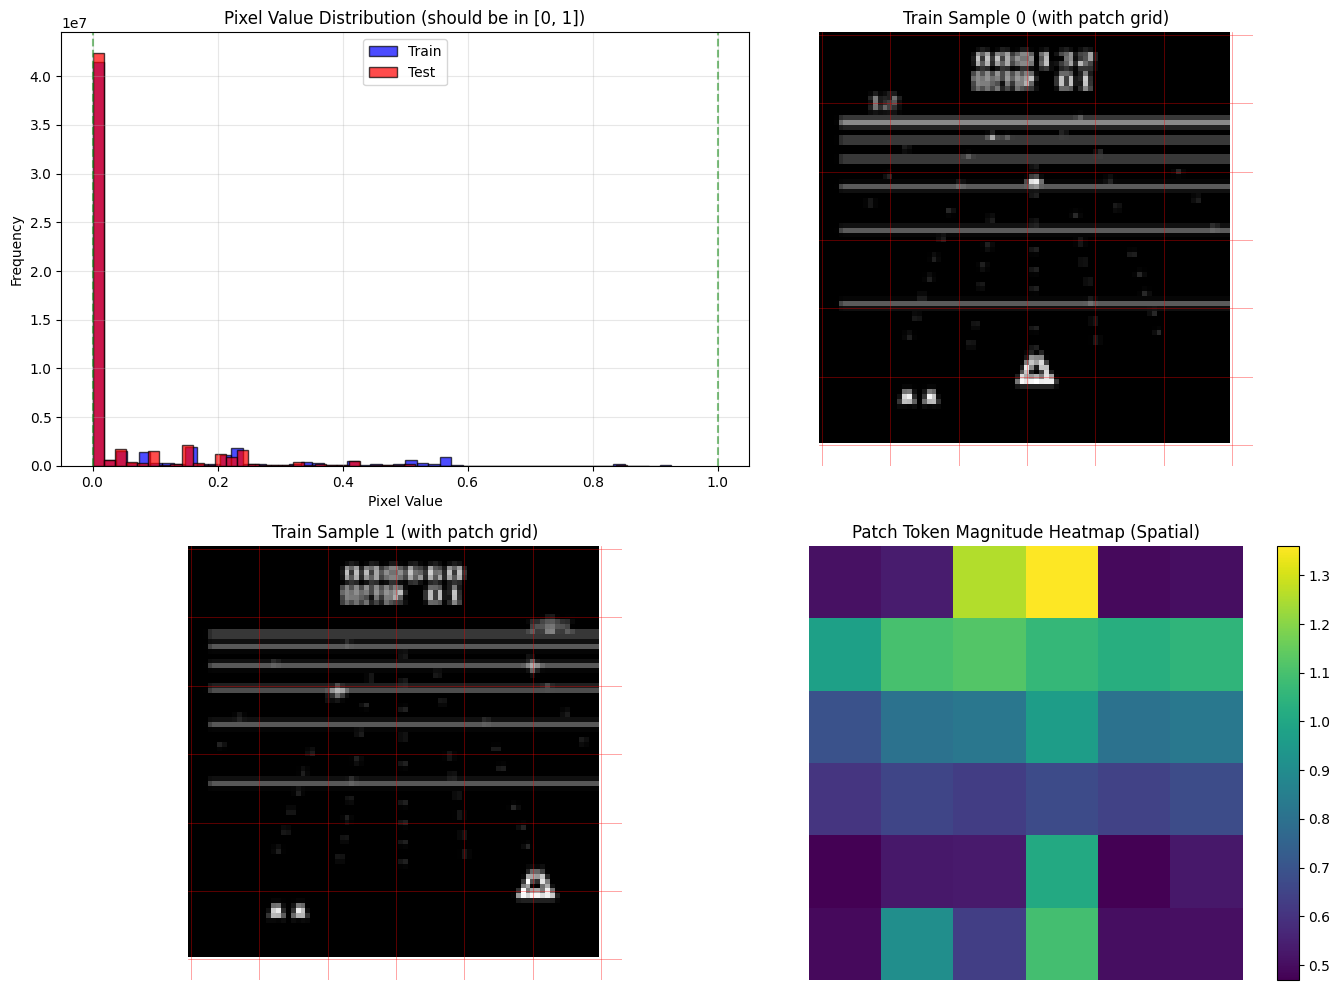

Verifying tokenization...
Checking data consistency...
Comparing train/test splits...


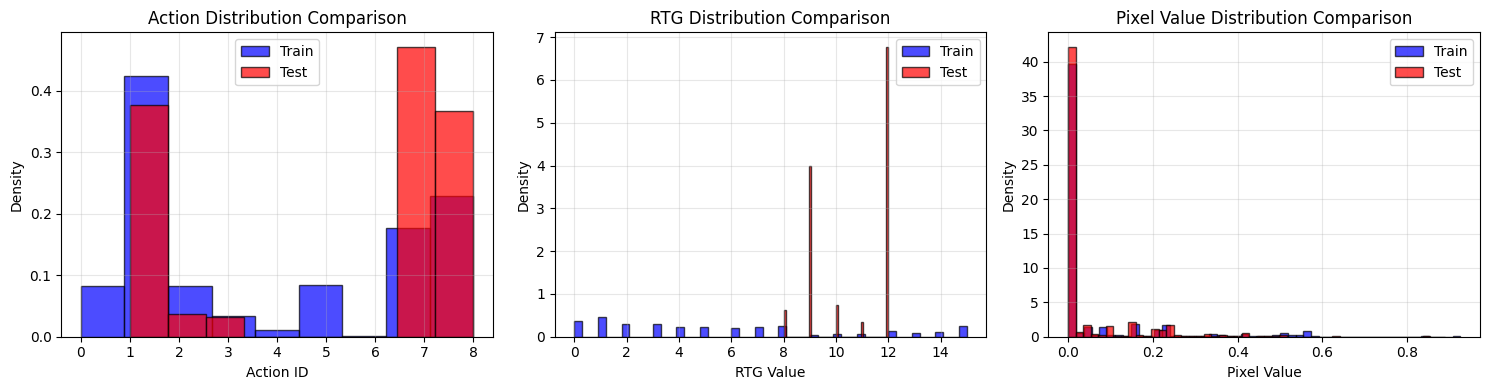

Generating sample visualizations...


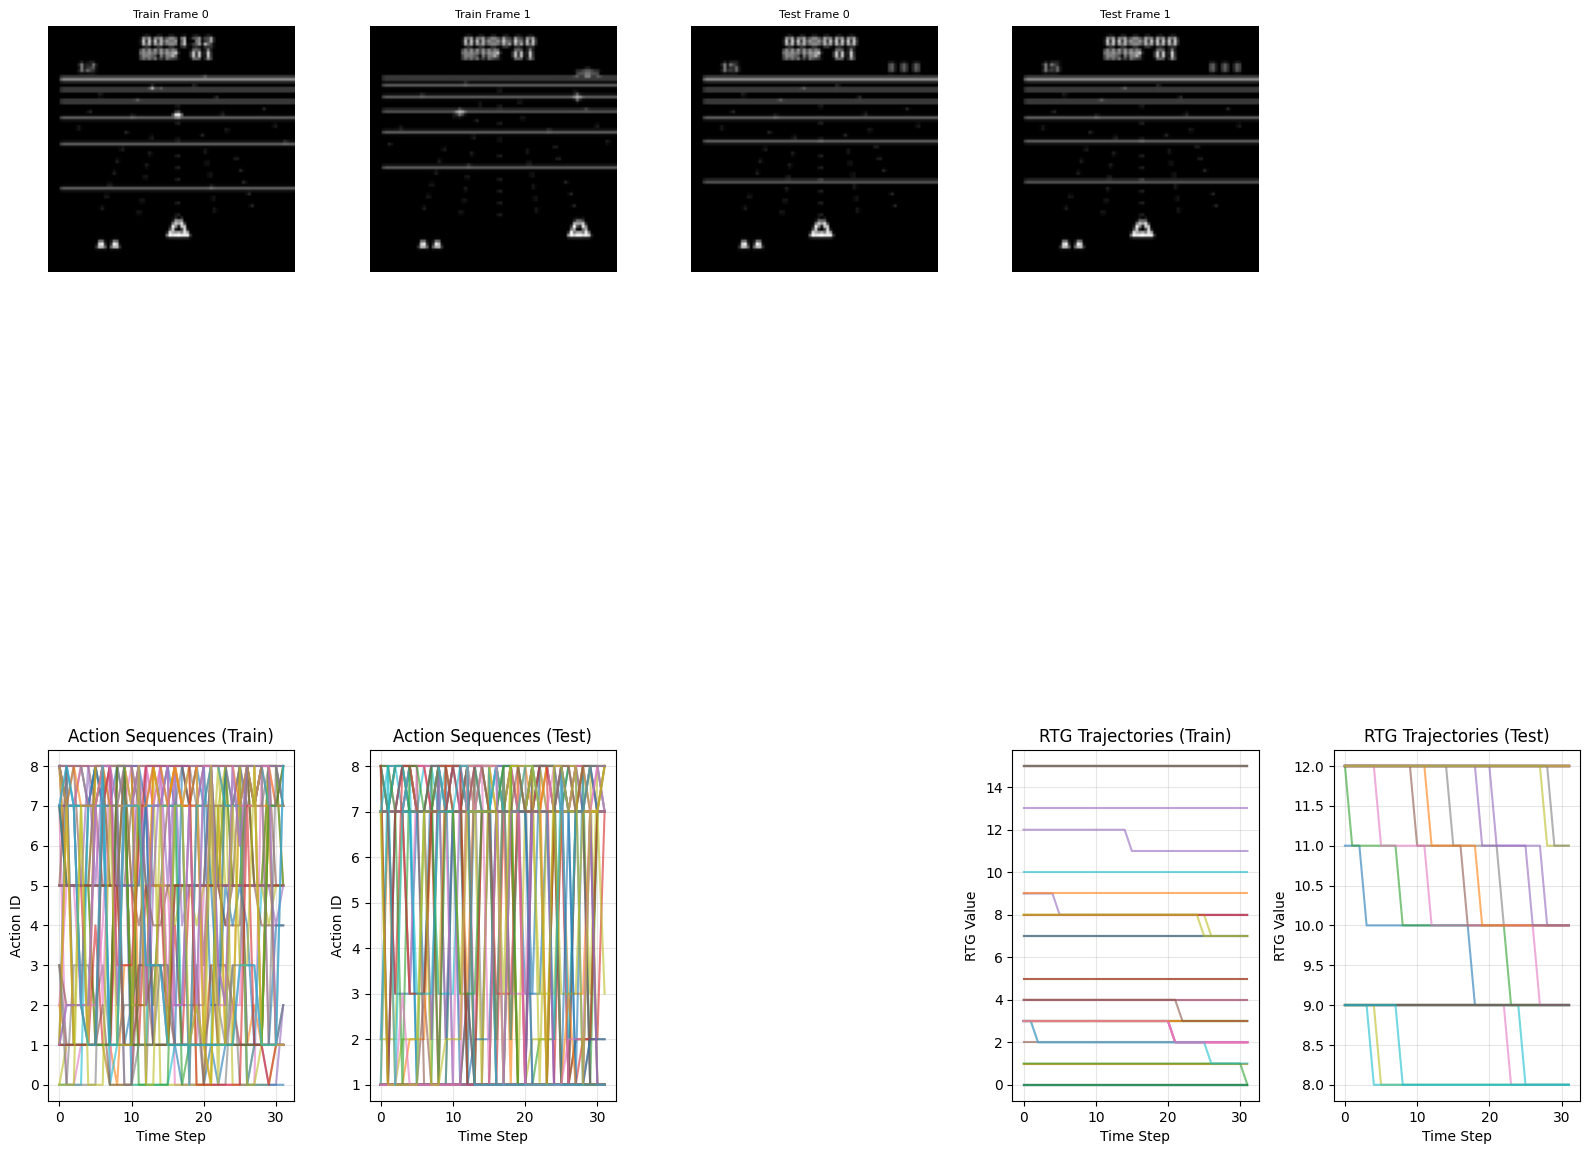


Diagnostics complete! Results saved to diagnostics
Summary: diagnostics\summary_stats.txt

=== Tokenization Verification ===
All checks passed: True
  - Tokens per step valid: True
  - Sequence length valid: True
  - Action tokens match: True
  - RTG IDs valid: True

=== Data Consistency ===
All consistent: True
  - Train batch/seq match: True, True
  - Test batch/seq match: True, True

=== Action Distribution ===
Train actions valid: True (range: 0-8, unique: 9)
Test actions valid: True (range: 1-8, unique: 5)

=== Image Encoding ===
Train normalized: True (pixel range: [0.000, 0.925])
Test normalized: True (pixel range: [0.000, 0.890])

=== RTG Distribution ===
Train RTG range: [0.00, 15.00], mean: 5.60
Train RTG clipped: 0 (0.00%)
Train RTG bins used: 16/121


In [4]:
from diagnostics import generate_diagnostics

# Generate comprehensive diagnostics
stats = generate_diagnostics(
    train_loader=train_loader,
    test_loader=test_loader,
    tokenizer=tokenizer,
    device=device,
    max_samples=500,  # Limit for quick diagnostics
    save_dir="diagnostics",
    show_plots=True,
)

# Print key validation results
print("\n=== Tokenization Verification ===")
print(f"All checks passed: {stats['tokenization']['all_checks_passed']}")
print(f"  - Tokens per step valid: {stats['tokenization']['tokens_per_step_valid']}")
print(f"  - Sequence length valid: {stats['tokenization']['seq_len_valid']}")
print(f"  - Action tokens match: {stats['tokenization']['action_tokens_match']}")
print(f"  - RTG IDs valid: {stats['tokenization']['rtg_ids_valid']}")

print("\n=== Data Consistency ===")
print(f"All consistent: {stats['consistency']['all_consistent']}")
print(f"  - Train batch/seq match: {stats['consistency']['checks']['train']['batch_match']}, {stats['consistency']['checks']['train']['seq_match']}")
print(f"  - Test batch/seq match: {stats['consistency']['checks']['test']['batch_match']}, {stats['consistency']['checks']['test']['seq_match']}")

print("\n=== Action Distribution ===")
print(f"Train actions valid: {stats['action']['train_valid']} (range: {stats['action']['train_min']}-{stats['action']['train_max']}, unique: {stats['action']['train_unique']})")
print(f"Test actions valid: {stats['action']['test_valid']} (range: {stats['action']['test_min']}-{stats['action']['test_max']}, unique: {stats['action']['test_unique']})")

print("\n=== Image Encoding ===")
print(f"Train normalized: {stats['image']['train_normalized']} (pixel range: [{stats['image']['train_pixel_min']:.3f}, {stats['image']['train_pixel_max']:.3f}])")
print(f"Test normalized: {stats['image']['test_normalized']} (pixel range: [{stats['image']['test_pixel_min']:.3f}, {stats['image']['test_pixel_max']:.3f}])")

print("\n=== RTG Distribution ===")
print(f"Train RTG range: [{stats['rtg']['train_min']:.2f}, {stats['rtg']['train_max']:.2f}], mean: {stats['rtg']['train_mean']:.2f}")
print(f"Train RTG clipped: {stats['rtg']['train_clipped']} ({stats['rtg']['train_clip_pct']:.2f}%)")
print(f"Train RTG bins used: {stats['rtg']['train_bins_used']}/{stats['rtg']['n_rtg_bins']}")


In [5]:
# # Create model
# model = MultiGameDecisionTransformer(
#     d_model=d_model,
#     n_actions=n_actions,
#     n_layers=2,
#     n_heads=4,
#     dim_feedforward=4 * d_model,
#     dropout=0.1,
#     max_seq_len=2048,
# )

# # Train the model
# trained_model, train_losses, val_losses = train(
#     model=model,
#     tokenizer=tokenizer,
#     train_loader=train_loader,
#     test_loader=test_loader,
#     num_epochs=1,
#     learning_rate=1e-4,
#     n_games=n_games,
#     eval_every_n_epochs=1,
# )